# Lie-Equivariant Quantum Graph Neural Network (Lie-EQGNN)

In this notebook, we will walk you through an interesting application for hybrid quantum-classical machine learning. Specifically, we will be covering the architecture from the "[Lie-Equivariant Quantum Graph Neural Network (Lie-EQGNN)](https://arxiv.org/abs/2411.15315)" paper. There is substantial evidence showing that QML models can suffer from poor trainability and generalization [2,3,4], and a well-known phenomenon that illustrates this is the concentration of measure, also known in the community as barren plateaus. Essentially, high-dimensional functions tend to have their measures concentrated around their mean [5]. This results in a flatter landscape, with gradients going close to zero, making it challenging to locate minima. For QML, this is especially true, since our models generally work in exponentially large Hilbert spaces compared to classical neural networks, for instance. As a consequence, efficiently designing new parameterized circuit architectures is crucial. In this tutorial, we explore a hybrid and symmetry-preserving architecture for an important task in particle physics known as jet tagging. By preserving symmetries, we potentially gain many benefits, like reduced sample and model complexity, and improved generalization bounds - due to an effectively reduced hypothesis space.

Below, we begin by importing all the necessary packages, and notice that, for QiBO, we'll be using the PyTorch backend for this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from scipy.sparse import coo_matrix

from qibo.symbols import Z, I
from qibo.hamiltonians import SymbolicHamiltonian
from qiboml.models.encoding import PhaseEncoding
from qibo import Circuit, gates, hamiltonians
from qiboml.models.decoding import QuantumDecoding
from qiboml.interfaces.pytorch import QuantumModel
from qibo import set_backend

set_backend("qiboml",platform="pytorch")

[Qibo 0.2.18|INFO|2025-06-17 06:43:20]: Using qiboml (pytorch) backend on cuda:0


# 1. Dataset

In this work, we consider the task of determining whether a given particle jet originated from a quark or a gluon (this is known as jet-tagging). For illustration we use the high energy physics dataset $\text{\textit{Pythia8 Quark and Gluon Jets for Energy Flow}}$ (Patrick T. Komiske et al, 2019), which contains two million jets split equally into one million quark jets and one million gluon jets. These jets resulted from LHC collisions with total center of mass energy $\sqrt{s} = 14$ TeV and were selected to have transverse momenta $p_T^{jet}$ between $500$ to $550$ GeV and rapidities $|y^{jet}| < 1.7$. For our analysis, we randomly picked $N = 12500$ jets and used the first $10000$ for training, the next $1250$ for validation, and the last $1250$ for testing. These sets happened to contain $4982$, $658$, and $583$ quark jets, respectively.

<img src="../figures/particle_cloud_mpgan.png" width=65% style="margin-left:auto; margin-right:auto">

*(Figure: the coordinate system (left) used to represent components of the particle momentum $\vec{p}$. Schematic representation of a gluon jet (middle) and a quark jet (right). The jet constituents (solid lines)  are collimated around the jet axis. [Figure adapted from Fig.~1 in (Raghav Kansal et al, 2021).])*


For our purposes, we consider the jet dataset to be constituted of point-clouds, where each jet is represented as a graph $\mathcal{G} = \{\mathcal{V,E}\}$, i.e., a set of nodes and edges, respectively. (This is the natural data structure used by Graph Neural Networks.) In our case, each node has the transverse momentum $p_T$, pseudorapidity $\eta$, azimuthal angle $\phi$ (and other scalar-like quantities like particle ID, particle mass, etc.) of the respective constituent particle in the jet (see the Figure above). Generally, the number of features is always constant, but the number of nodes in each jet may vary. For our analysis we used jets with at least 10 particles.

In [2]:
# to begin loading the jets, we will need some auxiliary functions to handle the graphical format.
# Feel free to just run this part and skip to the next section, where the model is defined.

def get_adj_matrix(n_nodes, batch_size, edge_mask):
    rows, cols = [], []
    for batch_idx in range(batch_size):
        nn = batch_idx*n_nodes
        x = coo_matrix(edge_mask[batch_idx])
        rows.append(nn + x.row)
        cols.append(nn + x.col)
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)
    edges = [torch.LongTensor(rows), torch.LongTensor(cols)]
    
    return edges

def collate_fn(data):
    data = list(zip(*data)) # label p4s nodes atom_mask
    data = [torch.stack(item) for item in data]
    batch_size, n_nodes, _ = data[1].size()
    atom_mask = data[-1]
    edge_mask = data[-2]
    edges = get_adj_matrix(n_nodes, batch_size, edge_mask)
    return data + [edges]


def load_jets(p4s, nodes, labels, atom_mask, edge_mask, edges, batch_size, train_ratio, val_ratio, test_ratio):
  
    # Create a TensorDataset
    dataset_all = TensorDataset(labels, p4s, nodes, atom_mask, edge_mask)
    
    # Calculate the lengths for each split
    total_size = len(dataset_all)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size  # Ensure all data is used
    
    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset_all, [train_size, val_size, test_size])
    
    # Create a dictionary to hold the datasets
    datasets = {
        "train": train_dataset,
        "val": val_dataset,
        "test": test_dataset
    }
    
    dataloaders = {split: DataLoader(dataset,
                                     batch_size=batch_size,
                                     pin_memory=False,
                                     collate_fn = collate_fn,
                                     drop_last=True if (split == 'train') else False,
                                     num_workers=0)
                        for split, dataset in datasets.items()}

    return dataloaders

## Let's load the jet tagging dataset

In [3]:
p4s = torch.load('../data/p4s.pt')
nodes = torch.load('../data/nodes.pt')
labels = torch.load('../data/labels.pt')
atom_mask = torch.load('../data/atom_mask.pt')
edge_mask = torch.from_numpy(np.load('../data/edge_mask.npy'))
edges = torch.from_numpy(np.load('../data/edges.npy'))

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataloaders = load_jets(p4s, nodes, labels, atom_mask, edge_mask, edges, 16, train_ratio, val_ratio, test_ratio)

### Variables for jet tagging:

In [4]:
print(f"""p4s: \t{p4s.shape},
nodes: \t{nodes.shape},
labels: \t{labels.shape},
atom_mask: \t{atom_mask.shape}, 
edge_mask: \t{edge_mask.shape},
edges: \t{edges.shape}""")

p4s: 	torch.Size([12500, 3, 4]),
nodes: 	torch.Size([12500, 3, 1]),
labels: 	torch.Size([12500]),
atom_mask: 	torch.Size([12500, 3]), 
edge_mask: 	torch.Size([12500, 3, 3]),
edges: 	torch.Size([2, 75000])


p4s:       4-momentum tensor of particles in each jet sample with shape [n_samples, n_particles, 4] 
            
nodes:     Additional features per particle (e.g., PID or learned embedding), shape [n_samples, n_particles, 1]

labels:    Jet-level labels for classification (e.g., quark vs gluon), shape [n_samples]

atom_mask: Binary mask indicating which particles are valid (not padding), shape [n_samples, n_particles]

edge_mask: Binary mask indicating which particle-pair interactions (edges) are valid, shape [n_samples, n_particles, n_particles]

edges:     Edge list for message-passing (graph connectivity), shape [2, n_edges], with each column (src, dst) across all samples


# 2. Quantum and Classical Graph Neural Networks

Graph Neural Networks (GNNs) are a class of neural networks designed to operate on graph-structured data. Unlike traditional neural networks that work on Euclidean data such as images or sequences, GNNs are capable of capturing the dependencies and relationships between nodes in a graph. The fundamental idea behind is to iteratively update the representation of each node by aggregating information from its neighbors, thereby enabling the network to learn both local and global graph structures.

Given the inherent graph structure of our dataset, which captures the complex interactions and relationships between particles, it is natural to employ graph neural networks (GNNs) for the task of tagging quarks versus gluons. GNNs have been successfully applied in particle physics for such classification tasks, as discussed in the paper "[Graph Neural Networks in Particle Physics](https://arxiv.org/abs/2007.13681)" by Shlomi et al. (2020). We start our approach with another classical, symmetry-preserving GNN to establish a foundational understanding and then discuss how we can extend this setting to introduce quantum computing.

To start, let $ G = (V, E) $ be a graph where $ V $ is its corresponding, set of nodes and $ E $ is its set of edges. Each node $ v \in V $ has an initial feature vector $ \mathbf{h}_v^{(0)} $, which is updated throughout multiple layers of the GNN. At each layer $ l $, the feature vector of the node $ v $ is updated by aggregating the neighboring feature vectors $ \mathcal{N}(v) $, and then combining them with its own features. The final node representations can be used for various downstream tasks such as node classification, link prediction, or graph classification. The latter is our case.

# A primer to invariance-equivariance constraint

As a simple way to illustrate how it is possible to bake a group-equivariance constraint into a GNN, consider a dataset of graphs in which its nodes have cartesian coordinates as inputs features, and let $SO(2)$ - the group of $2D$ rotations - be their underlying symmetry group. Since the Euclidean norm is invariant to rotations, any node-updating function of the form:

\begin{equation}
    x_{i}^{l+1} = x_{i}^{l} + C\sum_{j\in \mathcal{N}(i)} (x_{i}^{l} - x_{j}^{l})\;\phi_x (m_{ij}^{l})
\end{equation}

is naturally equivariant, where $\phi_x$ can be a classical neural network, and $m_{ij}^{l}$ is the edge message between nodes $i$ and $j$ in layer $l$. To see why equivariance holds in this case, we just need to see that, for any arbitrary rotation matrix $R$:

\begin{align}
    R x_{i}^{l+1} &= R x_{i}^{l} + C\sum_{j\in \mathcal{N}(i)} (R x_{i}^{l} - R x_{j}^{l})\;\phi_x (m_{ij}^{l})\\
    &= R x_{i}^{l} + C\sum_{j\in \mathcal{N}(i)} R (x_{i}^{l} - x_{j}^{l})\;\phi_x (m_{ij}^{l})\\
    &= R(x_{i}^{l} + C\sum_{j\in \mathcal{N}(i)}(x_{i}^{l} - x_{j}^{l})\;\phi_x (m_{ij}^{l}) )
\end{align}

This means that applying a rotation from the inside, directly transforming the data points (nodes), and then updating their coordinate, is equivalent to applying a rotation from the outside, that is, first updating their coordinate, and then acting with the group. The equation above implies that $m_{ij}^{l}$ also needs to be invariant, which can be achieved by having its inputs also being invariant measures,  like the euclidean norm given above and the standard dot-product, since $\langle x, y\rangle = \langle Rx, Ry\rangle$; it is easy to check, then, that equivariance breaks on the contrary. In the next section, we show how using a very similar formulation allows us to preserve the Lorentz group, a key symmetry in all of relativistic quantum field theory and inherent to almost all tasks involving high-energy particle scattering experiments, like we do in the Large Hadron Collider (LHC), at CERN.

# 3. LorentzNet
The first Lorentz-group preserving architecture we shall see is a very well known one in the particle physics community, called **LorentzNet** ([arXiv:2201.08187](https://arxiv.org/abs/2201.08187)). This is going to be a classical model, and through the course of this tutorial we'll understand where to fit in quantum computing, which will be the heart of our approach. Before any quantum, let's see what this classical model is doing first. The whole idea is to preserve the group actions by using universally-approximating Lorentz-equivariant polynomials, which will be responsible for the message passing scheme, and also updating the particle scalar and four-momentum latent representations. We can illustrate it as follows:

<center>
<img src="../figures/LorentzNet.png" width="65%" style="margin-left:auto; margin-right:auto">
</center>

*(Figure: Schematic representation of the LorentzNet architecture.)*


From the beginning, the **input** here consists of a concatenation of four-momentum vectors (called just particle coordinates from now on) and additional scalar features, like color, charge, flavor, etc. The combined feature vector for each particle (node) is:

$$
f_i = v_i \oplus s_i,
$$

where $\oplus$ denotes concatenation. Next, we turn to the core building block of this architecture:

**Lorentz Group Equivariant Block (LGEB)**

This is where the node and edge features are updated while preserving the Lorentz equivariance. The key components are symmetry-preserving functions for updating the coordinate, scalar and edge message features. Let's check:

1. **Invariant Edge Message Function $\phi_e$**:
   - Computes messages passed between particles.
   - Captures pairwise interactions and relativistic geometrical relationships.
   - Depends on Lorentz-invariant scalars, hence the edge message is invariant.
     
2. **Equivariant Coordinate Update Function $\phi_x$**:
   - Updates the coordinate embeddings of particles.
   - Incorporates attention mechanisms respecting Minkowski spacetime.
   - Ensures Lorentz-equivariance in its definition.
     
3. **Invariant Scalar Feature Update Function $\phi_h$**:
   - Updates scalar features of particles.
   - Aggregates information from neighboring particles.
   - Again, depends on Lorentz-invariant scalar features, so it is also invariant.
     
These functions are modeled using neural networks capable of approximating continuous functions. Here, in each $\phi$, we are going to introduce quantum neural networks to add more expressivity to the mix. Since QNNs are also universal approximators, we are good to go.

## 3.3. Detailed Formulation

1. **Edge Message Computation $\phi_e$**:

   For particles $i$ and $j$ at layer $l$, the **edge message** $m_{ij}^{l}$ is computed as:

   $$
   m_{ij}^{l} = \phi_e \left( h_i^{l}, h_j^{l}, \psi\left( \| x_i^{l} - x_j^{l} \|^2 \right), \psi\left( \langle x_i^{l}, x_j^{l} \rangle \right) \right),
   $$

   where:

   - $h_i^{l}$ and $h_j^{l}$ are the scalar features of particles $i$ and $j$ at layer $l$.
   - $x_i^{l}$ and $x_j^{l}$ are the coordinate embeddings (four-vectors) at layer $l$.
   - $\| x_i^{l} - x_j^{l} \|^2$ is the squared Minkowski **distance** between particles $i$ and $j$.
   - $\langle x_i^{l}, x_j^{l} \rangle$ is the Minkowski **inner product** (Lorentz dot product).
   - $\psi(\cdot)$ is a normalization function to help stabilize the gradients due to large numbers, and is defined in the paper as:

     $$
     \psi(a) = \operatorname{sgn}(a) \cdot \log\left( |a| + 1 \right),
     $$

     with $\operatorname{sgn}(a)$ being the sign function.

2. **Coordinate Embedding Update $\phi_x$**:

   The **coordinate embeddings** of particles are updated by a neighborhood-dependent equivariant function:

   $$
   x_i^{l+1} = x_i^{l} + c \sum_{j \in \mathcal{N}(i)} \phi_x ( m_{ij}^{l}) \cdot x_j^{l},
   $$

   where:

   - $\mathcal{N}(i)$ denotes the **neighborhood** of particle $i$, i.e., particles connected to $i$ in the graph.
   - $c$ is a scaling constant controlling the update magnitude.
   - $\phi_x ( m_{ij}^{l})$ computes an **attention weight** based on the edge message $m_{ij}^{l}$.


3. **Scalar Feature Update $\phi_h$**:

   Finally, the **scalar features** are updated as:

   $$
   h_i^{l+1} = h_i^{l} + \phi_h \left( h_i^{l}, \sum_{j \in \mathcal{N}(i)} w_{ij}^{l} m_{ij}^{l} \right),
   $$

   where:

   - $w_{ij}^{l}$ is an **edge significance weight** calculated by:

     $$
     w_{ij}^{l} = \phi_m \left( m_{ij}^{l} \right) \in [0, 1],
     $$

     with $\phi_m$ being a neural network outputting values in the range [0, 1].

   - $\phi_h$ aggregates information from neighboring particles to update $h_i^{l}$.

The purpose of $w_{ij}^{l}$ is to learn the importance of the edge connecting particles $i$ and $j$, and $\phi_h$ integrates these weighted messages to refine the scalar features, so our model can potentially learn more complex interactions.

A noteworthy aspect of LorentzNet is its approach to handling outputs: although both **coordinate embeddings** $x_i^{l}$ and **scalar features** $h_i^{l}$ are updated through the layers, the final output only uses the **scalar features** $h_i^{L}$ from the last layer $L$. This strategy reduces redundancy and computational overhead because the edge messages $m_{ij}^{l}$ already incorporate information from both $x_i^{l}$ and $x_j^{l}$.
      
**Implementation Details**

To ensure fidelity with the original LorentzNet architecture and leverage existing optimizations, we utilize the official implementation provided by the authors:

- **Repository**: [LorentzNet-release](https://github.com/sdogsq/LorentzNet-release/tree/main)

## Let's define our parameterized circuits.

In order to measure multiple observables and perform gradient descent afterwards, the first thing that we'll need is to define a CustomDecoder. Before anything else, let's also define an auxiliary function to create a list of observables of the form

\begin{align*}
\text{Observables }=[\hat{\sigma}_z &\otimes \mathbb{I} \otimes \mathbb{I} \otimes \cdots \otimes \mathbb{I},\\
\mathbb{I} &\otimes \hat{\sigma}_z \otimes \mathbb{I} \otimes \cdots \otimes \mathbb{I},\\
\mathbb{I} &\otimes \mathbb{I} \otimes \hat{\sigma}_z \otimes \cdots \otimes \mathbb{I},\\
\mathbb{I} &\otimes \mathbb{I} \otimes \mathbb{I} \otimes \cdots \otimes \hat{\sigma}_z]
\end{align*}

In [5]:
def create_hamiltonians(n_qubits):

    measurements = []
    for i in range(n_qubits):
        hamiltonians = [I(i) for i in range(n_qubits)]
        hamiltonians[i] = Z(i)
    
        H = 1
        for term in hamiltonians:
            H *= term
            
        H = SymbolicHamiltonian(H)
        measurements.append(H)
    
    return measurements

In [6]:
class CustomDecoderMultipleZ(QuantumDecoding):

    def __init__(self, nqubits: int):
        super().__init__(nqubits)
        # build the observables using qibo's SymbolicHamiltonian
        self.nqubits = nqubits
        self.hamilts = create_hamiltonians(nqubits)

    def __call__(self, x: Circuit):
        # execute the circuit and collect the final state
        state = super().__call__(x).state()

        # collect expectation values (each one must be a torch Tensor!)
        expvals = [self.hamilts[i].expectation(state)        # scalar tensor
                   for i in range(self.nqubits)]

        # stack them without breaking the graph
        return torch.stack(expvals)      # shape (nqubits,)
        
    # specify the shape of the output
    @property
    def output_shape(self) -> tuple[int]:
        return (self.nqubits)

In [7]:

def create_quantum_net(n_qubits, nlayers):

    qubits = list(range(n_qubits))
    
    # define the encoding
    encoding = PhaseEncoding(nqubits=n_qubits)

    # build the computation circuit
    circuit = Circuit(n_qubits)

    decoding = CustomDecoderMultipleZ(n_qubits)
    
    circuit.add(gates.H(q) for q in qubits)
    for layer in range(nlayers):
        for q in qubits:
            circuit.add(gates.RY(q, theta=torch.randn(1) * np.pi, trainable=True)) # random.random()
            circuit.add(gates.RZ(q, theta=torch.randn(1) * np.pi, trainable=True))

        if n_qubits > 1:
            for i, q in enumerate(qubits[:-2]):
                circuit.add(gates.CNOT(q0=q, q1=qubits[i + 1]))
            circuit.add(gates.CNOT(q0=qubits[-1], q1=qubits[0]))

    return encoding, circuit, decoding

## Auxiliary functions

In [8]:
"""Some auxiliary functions"""

from math import sqrt
import numpy as np
import torch

# Speed of light (m/s)
c = 299792458

"""Lorentz transformations describe the transition between two inertial reference
frames F and F', each of which is moving in some direction with respect to the
other. This code only calculates Lorentz transformations for movement in the x
direction with no spatial rotation (i.e., a Lorentz boost in the x direction).
The Lorentz transformations are calculated here as linear transformations of
four-vectors [ct, x, y, z] described by Minkowski space. Note that t (time) is
multiplied by c (the speed of light) in the first entry of each four-vector.

Thus, if X = [ct; x; y; z] and X' = [ct'; x'; y'; z'] are the four-vectors for
two inertial reference frames and X' moves in the x direction with velocity v
with respect to X, then the Lorentz transformation from X to X' is X' = BX,
where

    | γ  -γβ  0  0|
B = |-γβ  γ   0  0|
    | 0   0   1  0|
    | 0   0   0  1|

is the matrix describing the Lorentz boost between X and X',
γ = 1 / √(1 - v²/c²) is the Lorentz factor, and β = v/c is the velocity as
a fraction of c.
"""


def beta(velocity: float) -> float:
    """
    Calculates β = v/c, the given velocity as a fraction of c
    >>> beta(c)
    1.0
    >>> beta(199792458)
    0.666435904801848
    """
    if velocity > c:
        raise ValueError("Speed must not exceed light speed 299,792,458 [m/s]!")
    elif velocity < 1:
        # Usually the speed should be much higher than 1 (c order of magnitude)
        raise ValueError("Speed must be greater than or equal to 1!")

    return velocity / c


def gamma(velocity: float) -> float:
    """
    Calculate the Lorentz factor γ = 1 / √(1 - v²/c²) for a given velocity
    >>> gamma(4)
    1.0000000000000002
    >>> gamma(1e5)
    1.0000000556325075
    >>> gamma(3e7)
    1.005044845777813
    >>> gamma(2.8e8)
    2.7985595722318277
    """
    return 1 / sqrt(1 - beta(velocity) ** 2)


def transformation_matrix(velocity: float) -> np.ndarray:
    """
    Calculate the Lorentz transformation matrix for movement in the x direction:

    | γ  -γβ  0  0|
    |-γβ  γ   0  0|
    | 0   0   1  0|
    | 0   0   0  1|

    where γ is the Lorentz factor and β is the velocity as a fraction of c
    >>> transformation_matrix(29979245)
    array([[ 1.00503781, -0.10050378,  0.        ,  0.        ],
           [-0.10050378,  1.00503781,  0.        ,  0.        ],
           [ 0.        ,  0.        ,  1.        ,  0.        ],
           [ 0.        ,  0.        ,  0.        ,  1.        ]])
    """
    return np.array(
        [
            [gamma(velocity), -gamma(velocity) * beta(velocity), 0, 0],
            [-gamma(velocity) * beta(velocity), gamma(velocity), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ]
    )



def unsorted_segment_sum(data, segment_ids, num_segments):
    r'''Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`.
    Adapted from https://github.com/vgsatorras/egnn.
    '''
    result = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    return result

def unsorted_segment_mean(data, segment_ids, num_segments):
    r'''Custom PyTorch op to replicate TensorFlow's `unsorted_segment_mean`.
    Adapted from https://github.com/vgsatorras/egnn.
    '''
    result = data.new_zeros((num_segments, data.size(1)))
    count = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    count.index_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

def normsq4(p):
    r''' Minkowski square norm
         `\|p\|^2 = p[0]^2-p[1]^2-p[2]^2-p[3]^2`
    ''' 
    psq = torch.pow(p, 2)
    return 2 * psq[..., 0] - psq.sum(dim=-1)
    
def dotsq4(p,q):
    r''' Minkowski inner product
         `<p,q> = p[0]q[0]-p[1]q[1]-p[2]q[2]-p[3]q[3]`
    '''
    psq = p*q
    return 2 * psq[..., 0] - psq.sum(dim=-1)

def normA_fn(A):
    return lambda p: torch.einsum('...i, ij, ...j->...', p, A, p)

def dotA_fn(A):
    return lambda p, q: torch.einsum('...i, ij, ...j->...', p, A, q)
    
def psi(p):
    ''' `\psi(p) = Sgn(p) \cdot \log(|p| + 1)`
    '''
    return torch.sign(p) * torch.log(torch.abs(p) + 1)





##############################


def makedir(path):
    try:
        os.makedirs(path)
    except OSError:
        pass

def args_init(args):
    r''' Initialize seed and exp_name.
    '''
    if args.seed is None: # use random seed if not specified
        args.seed = np.random.randint(100)
    if args.exp_name == '': # use random strings if not specified
        args.exp_name = ''.join(random.choices(string.ascii_lowercase + string.digits, k=8))
    if (args.local_rank == 0): # master
        print(args)
        makedir(f"{args.logdir}/{args.exp_name}")
        with open(f"{args.logdir}/{args.exp_name}/args.json", 'w') as f:
            json.dump(args.__dict__, f, indent=4)

def sum_reduce(num, device):
    r''' Sum the tensor across the devices.
    '''
    if not torch.is_tensor(num):
        rt = torch.tensor(num).to(device)
    else:
        rt = num.clone()
    dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    return rt

from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

class GradualWarmupScheduler(_LRScheduler):
    """ Gradually warm-up(increasing) learning rate in optimizer.
    Proposed in 'Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour'.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        multiplier: target learning rate = base lr * multiplier if multiplier > 1.0. if multiplier = 1.0, lr starts from 0 and ends up with the base_lr.
        warmup_epoch: target learning rate is reached at warmup_epoch, gradually
        after_scheduler: after target_epoch, use this scheduler(eg. ReduceLROnPlateau)
    Reference:
        https://github.com/ildoonet/pytorch-gradual-warmup-lr
    """

    def __init__(self, optimizer, multiplier, warmup_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.warmup_epoch = warmup_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    @property
    def _warmup_lr(self):
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch + 1) / self.warmup_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * (self.last_epoch + 1) / self.warmup_epoch + 1.) for base_lr in self.base_lrs]

    def get_lr(self):
        if self.last_epoch >= self.warmup_epoch - 1:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        return self._warmup_lr

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        self.last_epoch = self.last_epoch + 1 if epoch==None else epoch
        if self.last_epoch >= self.warmup_epoch - 1:
            if not self.finished:
                warmup_lr = [base_lr * self.multiplier for base_lr in self.base_lrs]
                for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                    param_group['lr'] = lr
                self.finished = True
                return
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.warmup_epoch)
            return

        for param_group, lr in zip(self.optimizer.param_groups, self._warmup_lr):
            param_group['lr'] = lr

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.warmup_epoch)
                self.last_epoch = self.after_scheduler.last_epoch + self.warmup_epoch + 1
                self._last_lr = self.after_scheduler.get_last_lr()
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

        self._last_lr = [group['lr'] for group in self.optimizer.param_groups]

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.

        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        result = {key: value for key, value in self.__dict__.items() if key != 'optimizer' or key != "after_scheduler"}
        if self.after_scheduler:
            result.update({"after_scheduler": self.after_scheduler.state_dict()})
        return result

    def load_state_dict(self, state_dict):
        after_scheduler_state = state_dict.pop("after_scheduler", None)
        self.__dict__.update(state_dict)
        if after_scheduler_state:
            self.after_scheduler.load_state_dict(after_scheduler_state)


from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

def buildROC(labels, score, targetEff=[0.3,0.5]):
    r''' ROC curve is a plot of the true positive rate (Sensitivity) in the function of the false positive rate
    (100-Specificity) for different cut-off points of a parameter. Each point on the ROC curve represents a
    sensitivity/specificity pair corresponding to a particular decision threshold. The Area Under the ROC
    curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups.
    '''
    if not isinstance(targetEff, list):
        targetEff = [targetEff]
    fpr, tpr, threshold = roc_curve(labels, score)
    idx = [np.argmin(np.abs(tpr - Eff)) for Eff in targetEff]
    eB, eS = fpr[idx], tpr[idx]
    return fpr, tpr, threshold, eB, eS

## Architecture

In [9]:
import torch
from torch import nn
import numpy as np

"""
    Quantum Lie-Equivariant Group Block (QLieGEB).
    
        - Given the Lie generators found (i.e.: through LieGAN, oracle-preserving latent flow, or some other approach
          that we develop further), once the metric tensor J is found via the equation:

                          L.J + J.(L^T) = 0,
                          
          we just have to specify the metric to make the model symmetry-preserving to the corresponding Lie group. 
          In the cells below, I will show first how the model preserves symmetries (starting with the default Lorentz group),
          and when we change J to some other metric (Euclidean, for example), Lorentz boosts break equivariance, while other
          transformations preserve it (rotations, for the example shown in the cells below)
"""
class QLieGEB(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_node_attr=0,
                 dropout = 0., c_weight=1.0, last_layer=False, A=None, include_x=False, 
                 model_type='classical', nlayers_qnn = 4, device='cpu'):
        
        super(QLieGEB, self).__init__()
        self.c_weight = c_weight
        self.model_type = model_type
        n_edge_attr = 2 if not include_x else 10 # dims for Minkowski norm & inner product
        
        self.device = device
        
        self.include_x = include_x

        """
            phi_e: input size: n_qubits -> output size: n_qubits
            n_hidden has to be equal to n_input (n_input * 2 + n_edge_attr),
            but this is just considering that this is a simple working example.
        """

        
        self.n_hidden = n_input * 2 + n_edge_attr
        
        if model_type in ['phi_e', 'quantum']:

            n_qubits=n_input * 2 + n_edge_attr

            self.n_output_e = self.n_hidden
            
            encoding, circuit, decoding = create_quantum_net(n_qubits, 
                                                             nlayers_qnn)
            q_circuit_e = QuantumModel([encoding, circuit], decoding)

            self.phi_e = nn.Sequential(q_circuit_e,
                                      nn.Linear(n_qubits, self.n_hidden),
                                      nn.ReLU())
            self.BatchNorm1d_e = nn.BatchNorm1d(self.n_hidden)
        else:
            self.phi_e = nn.Sequential(
                        nn.Linear(n_input * 2 + n_edge_attr, self.n_hidden, bias=False),
                        nn.BatchNorm1d(self.n_hidden),
                        nn.ReLU(),
                        nn.Linear(self.n_hidden, self.n_hidden),
                        nn.ReLU()).float()
            

        if model_type in ['phi_h', 'quantum']:
            
            n_qubits=self.n_hidden
            
            self.n_output_h = n_output
            
            encoding, circuit, decoding = create_quantum_net(n_qubits, 
                                                             nlayers_qnn)
            q_circuit_h = QuantumModel([encoding, circuit], decoding)

            self.phi_h = nn.Sequential(nn.Linear(self.n_hidden + n_input + n_node_attr, self.n_hidden, bias=False),
                                       # nn.BatchNorm1d(n_hidden),
                                       nn.ReLU(),
                                       q_circuit_h,
                                       nn.Linear(n_qubits, n_output))

            
            self.BatchNorm1d_h = nn.BatchNorm1d(4)
            
        else:
            self.phi_h = nn.Sequential(
                nn.Linear(self.n_hidden + n_input + n_node_attr, self.n_hidden),
                nn.BatchNorm1d(self.n_hidden),
                nn.ReLU(),
                nn.Linear(self.n_hidden, n_output))

        

        if model_type in ['phi_x', 'quantum']:
            down_projection = nn.Linear(self.n_hidden, 1, bias=False)
            torch.nn.init.xavier_uniform_(down_projection.weight, gain=0.001)

            n_qubits=self.n_hidden
            encoding, circuit, decoding = create_quantum_net(n_qubits, 
                                                             nlayers_qnn)
            q_circuit_x = QuantumModel([encoding, circuit], decoding)

            self.phi_x = nn.Sequential(q_circuit_x,
                                       down_projection)
            #down_projection is removed for now since we currently only
            # measure one observable at a time.
                        
        else:
            layer = nn.Linear(self.n_hidden, 1, bias=False)
            torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)
            self.phi_x = nn.Sequential(
                nn.Linear(self.n_hidden, self.n_hidden),
                nn.ReLU(),
                layer)

        
        if model_type in ['phi_m', 'quantum']:

            n_qubits=1
            encoding, circuit, decoding = create_quantum_net(n_qubits, 
                                                             nlayers_qnn,)
            q_circuit_m = QuantumModel([encoding, circuit], decoding)

            self.phi_m = nn.Sequential(nn.Linear(self.n_hidden, 1),
                                       nn.ReLU(),
                                       q_circuit_m)
        else:
            self.phi_m = nn.Sequential(
                nn.Linear(self.n_hidden, 1),
                nn.Sigmoid())    

        
        self.last_layer = last_layer
        if last_layer:
            del self.phi_x

        self.A = A
        self.norm_fn = normA_fn(A) if A is not None else normsq4
        self.dot_fn = dotA_fn(A) if A is not None else dotsq4

    def m_model(self, hi, hj, norms, dots):
        out = torch.cat([hi, hj, norms, dots], dim=1)

        if self.model_type in ["phi_e", "quantum"]:
            out2 = torch.empty(0, self.n_output_e).to(self.device)
            for x in out:
                out2 = torch.cat((out2, self.phi_e(x).unsqueeze(0).to(self.device)) )
    
            out = self.BatchNorm1d_e(out2)
        
        w = self.phi_m(out)
        out = out * w
        return out

    def m_model_extended(self, hi, hj, norms, dots, xi, xj):
        out = torch.cat([hi, hj, norms, dots, xi, xj], dim=1)
        out = self.phi_e(out).squeeze(0)
        w = self.phi_m(out)
        out = out * w
        return out

    def h_model(self, h, edges, m, node_attr):
        i, j = edges
        agg = unsorted_segment_sum(m, i, num_segments=h.size(0))
        agg = torch.cat([h, agg, node_attr], dim=1)


        if self.model_type in ["phi_h", "quantum"]:
            out = torch.empty(0, self.n_output_h).to(self.device)
            for x in agg:
                out = torch.cat((out, self.phi_h(x).unsqueeze(0).to(self.device)) )
            out = self.BatchNorm1d_h(out)
            out = h + out
        else:
            out = h + self.phi_h(agg)
            
        return out

    def x_model(self, x, edges, x_diff, m):
        i, j = edges
        
        # trans = x_diff * out
        trans = x_diff * self.phi_x(m)
        # From https://github.com/vgsatorras/egnn
        # This is never activated but just in case it explosed it may save the train
        trans = torch.clamp(trans, min=-100, max=100)
        agg = unsorted_segment_mean(trans, i, num_segments=x.size(0))
        x = x + agg * self.c_weight
        return x

    def minkowski_feats(self, edges, x):
        i, j = edges
        x_diff = x[i] - x[j]
        norms = self.norm_fn(x_diff).unsqueeze(1)
        dots = self.dot_fn(x[i], x[j]).unsqueeze(1)
        norms, dots = psi(norms), psi(dots)
        return norms, dots, x_diff

    def forward(self, h, x, edges, node_attr=None):
        i, j = edges
        norms, dots, x_diff = self.minkowski_feats(edges, x)

        if self.include_x:
            m = self.m_model_extended(h[i], h[j], norms, dots, x[i], x[j])
        else:
            m = self.m_model(h[i], h[j], norms, dots) # [B*N, hidden]
        if not self.last_layer:
            x = self.x_model(x, edges, x_diff, m)
        h = self.h_model(h, edges, m, node_attr)
        return h, x, m

class LieEQGNN(nn.Module):
    r''' Implementation of Lie-Equivariant Quantum Graph Neural Network (Lie-EQGNN).

    Args:
        - `n_scalar` (int): number of input scalars.
        - `n_hidden` (int): dimension of latent space.
        - `n_class`  (int): number of output classes.
        - `n_layers` (int): number of QLieGEB layers.
        - `c_weight` (float): weight c in the x_model.
        - `dropout`  (float): dropout rate.
    '''
    def __init__(self, n_scalar, n_hidden, n_class = 2, n_layers = 6, c_weight = 1e-3, dropout = 0., A=None, include_x=False,
                model_type='classical', nlayers_qnn = 4, device='cpu'):
        
        super(LieEQGNN, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.embedding = nn.Linear(n_scalar, n_hidden)
        self.QLieGEBs = nn.ModuleList([QLieGEB(self.n_hidden, self.n_hidden, self.n_hidden, 
                                    n_node_attr=n_scalar, dropout=dropout,
                                    c_weight=c_weight, last_layer=(i==n_layers-1), A=A, include_x=include_x,
                                    model_type=model_type, nlayers_qnn = nlayers_qnn, device=device)
                                    for i in range(n_layers)])
        
        self.graph_dec = nn.Sequential(nn.Linear(self.n_hidden, self.n_hidden),
                                       nn.ReLU(),
                                       nn.Dropout(dropout),
                                       nn.Linear(self.n_hidden, n_class)) # classification

    def forward(self, scalars, x, edges, node_mask, edge_mask, n_nodes, show_embeddings=False):
        h = self.embedding(scalars)

        if show_embeddings:
            print("Scalar embedding, h, before (first particle): \n", h[0].cpu().detach().numpy())
    
        for i in range(self.n_layers):
            h, x, _ = self.QLieGEBs[i](h, x, edges, node_attr=scalars)

        if show_embeddings:
            print("Scalar embedding, h, after transformation (first particle): \n", h[0].cpu().detach().numpy())
        
        h = h * node_mask
        h = h.view(-1, n_nodes, self.n_hidden)
        h = torch.mean(h, dim=1)
        pred = self.graph_dec(h)
        return pred.squeeze(1)

### Invariance-Equivariance analysis

Let's start with a default prediction:

In [10]:
label, p4s, nodes, atom_mask, edge_mask, edges = next(iter(dataloaders['test']))

In [11]:
dtype = torch.float64
device = 'cuda'

batch_size, n_nodes, _ = p4s.to(device, dtype).size()
atom_positions = p4s.view(batch_size * n_nodes, -1).to(device, dtype)
atom_mask = atom_mask.view(batch_size * n_nodes, -1).to(device, dtype)
edge_mask = edge_mask.reshape(batch_size * n_nodes * n_nodes, -1).to(device, dtype)
nodes = nodes.view(batch_size * n_nodes, -1).to(device, dtype)
edges = [a.to(device) for a in edges]
label = label.to(device, dtype).long()

In [12]:
model = LieEQGNN(n_scalar = 1, n_hidden = 4, n_class = 2,\
                   dropout = 0.2, n_layers = 4,\
                   c_weight = 1e-3, model_type="phi_x", 
                   nlayers_qnn = 3, device=device).to(device, dtype=torch.float64)

C:\Users\jogis\anaconda3\envs\qml_qibo\Lib\site-packages\torch\nn\modules\module.py:1341: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Copy.cpp:307.)
  return t.to(


In [13]:
pred = model(scalars=nodes, x= atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes, show_embeddings=True)

Scalar embedding, h, before (first particle): 
 [-0.09754075 -0.29659274 -0.30916309 -0.91381201]
Scalar embedding, h, after transformation (first particle): 
 [0.53184544 0.06022103 0.80105872 0.03766983]


## Invariance-Equivariance analysis 

* Does taking any random transformation in the four-momentum vectors (i.e.: multiplying by 0.1) preserve our particle's latent representation?

In [14]:
pred = model(scalars=nodes, x= 0.1 * atom_positions, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes, show_embeddings=True)

Scalar embedding, h, before (first particle): 
 [-0.09754075 -0.29659274 -0.30916309 -0.91381201]
Scalar embedding, h, after transformation (first particle): 
 [0.50751093 0.00851223 0.77186386 0.09182914]


* The logits have changed and we have broken the symmetry. Now, what about the Lorentz transformations?

In [15]:
pred = model(scalars=nodes, x= (torch.tensor(transformation_matrix(220000000)).to(device) @ atom_positions.to(device, dtype=torch.float64).T).to(device, dtype=torch.float32).T, edges=edges, node_mask=atom_mask,
                     edge_mask=edge_mask, n_nodes=n_nodes, show_embeddings=True)

Scalar embedding, h, before (first particle): 
 [-0.09754075 -0.29659274 -0.30916309 -0.91381201]
Scalar embedding, h, after transformation (first particle): 
 [0.53184545 0.06022105 0.80105875 0.0376698 ]


#### The latent representation is preserved when applying a Lorentz boost to our jet. We are preserving the symmetries!

## 5. Training

Finally, let's train on some data!

In [16]:
import os
import torch
from torch import nn, optim
import json, time
import numpy as np
# import torch.distributed as dist
# from torch.nn.parallel import DistributedDataParallel
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from tqdm import tqdm

def run(model, epoch, loader, partition, N_EPOCHS=None):
    if partition == 'train':
        model.train()
    else:
        model.eval()

    res = {'time':0, 'correct':0, 'loss': 0, 'counter': 0, 'acc': 0,
           'loss_arr':[], 'correct_arr':[],'label':[],'score':[]}

    tik = time.time()
    loader_length = len(loader)

    for i, (label, p4s, nodes, atom_mask, edge_mask, edges) in tqdm(enumerate(loader)):
        if partition == 'train':
            optimizer.zero_grad()
        
        batch_size, n_nodes, _ = p4s.size()
        atom_positions = p4s.view(batch_size * n_nodes, -1).to(device, dtype)
        atom_mask = atom_mask.view(batch_size * n_nodes, -1).to(device)
        edge_mask = edge_mask.reshape(batch_size * n_nodes * n_nodes, -1).to(device)
        nodes = nodes.view(batch_size * n_nodes, -1).to(device,dtype)
        edges = [a.to(device) for a in edges]
        label = label.to(device, dtype).long()

        pred = model(scalars=nodes, x=atom_positions, edges=edges, node_mask=atom_mask,
                         edge_mask=edge_mask, n_nodes=n_nodes)
        
        predict = pred.max(1).indices
        correct = torch.sum(predict == label).item()
        loss = loss_fn(pred, label)
        
        if partition == 'train':
            loss.backward()
            optimizer.step()
        elif partition == 'test':
            # save labels and probilities for ROC / AUC
            # print("Preds ", pred)
            score = torch.nn.functional.softmax(pred, dim = -1)
            # print("Score test ", score)
            # raise
            res['label'].append(label)
            res['score'].append(score)

        res['time'] = time.time() - tik
        res['correct'] += correct
        res['loss'] += loss.item() * batch_size
        res['counter'] += batch_size
        res['loss_arr'].append(loss.item())
        res['correct_arr'].append(correct)

        # if i != 0 and i % args.log_interval == 0:
        
    running_loss = sum(res['loss_arr'])/len(res['loss_arr'])
    running_acc = sum(res['correct_arr'])/(len(res['correct_arr'])*batch_size)
    avg_time = res['time']/res['counter'] * batch_size
    tmp_counter = res['counter']
    tmp_loss = res['loss'] / tmp_counter
    tmp_acc = res['correct'] / tmp_counter

    if N_EPOCHS:
        print(">> %s \t Epoch %d/%d \t Batch %d/%d \t Loss %.4f \t Running Acc %.3f \t Total Acc %.3f \t Avg Batch Time %.4f" %
             (partition, epoch + 1, N_EPOCHS, i, loader_length, running_loss, running_acc, tmp_acc, avg_time))
    else:
        print(">> %s \t Loss %.4f \t Running Acc %.3f \t Total Acc %.3f \t Avg Batch Time %.4f" %
             (partition, running_loss, running_acc, tmp_acc, avg_time))
        
    torch.cuda.empty_cache()
    # ---------- reduce -----------
    if partition == 'test':
        res['label'] = torch.cat(res['label']).unsqueeze(-1)
        res['score'] = torch.cat(res['score'])
        res['score'] = torch.cat((res['label'],res['score']),dim=-1)
    res['counter'] = res['counter']
    res['loss'] = res['loss'] / res['counter']
    res['acc'] = res['correct'] / res['counter']
    return res

def train(model, res, N_EPOCHS, model_path, log_path):
    ### training and validation
    for epoch in range(N_EPOCHS):
        train_res = run(model, epoch, dataloaders['train'], partition='train', N_EPOCHS = N_EPOCHS)
        print("Time: train: %.2f \t Train loss %.4f \t Train acc: %.4f" % (train_res['time'],train_res['loss'],train_res['acc']))
        # if epoch % args.val_interval == 0:
            
        # if (args.local_rank == 0):
        torch.save(model.state_dict(), os.path.join(model_path, "checkpoint-epoch-{}.pt".format(epoch)) )
        with torch.no_grad():
            val_res = run(model, epoch, dataloaders['val'], partition='val')
            
        # if (args.local_rank == 0): # only master process save
        res['lr'].append(optimizer.param_groups[0]['lr'])
        res['train_time'].append(train_res['time'])
        res['val_time'].append(val_res['time'])
        res['train_loss'].append(train_res['loss'])
        res['train_acc'].append(train_res['acc'])
        res['val_loss'].append(val_res['loss'])
        res['val_acc'].append(val_res['acc'])
        res['epochs'].append(epoch)

        ## save best model
        if val_res['acc'] > res['best_val']:
            print("New best validation model, saving...")
            torch.save(model.state_dict(), os.path.join(model_path,"best-val-model.pt"))
            res['best_val'] = val_res['acc']
            res['best_epoch'] = epoch

        print("Epoch %d/%d finished." % (epoch, N_EPOCHS))
        print("Train time: %.2f \t Val time %.2f" % (train_res['time'], val_res['time']))
        print("Train loss %.4f \t Train acc: %.4f" % (train_res['loss'], train_res['acc']))
        print("Val loss: %.4f \t Val acc: %.4f" % (val_res['loss'], val_res['acc']))
        print("Best val acc: %.4f at epoch %d." % (res['best_val'],  res['best_epoch']))

        json_object = json.dumps(res, indent=4)
        with open(os.path.join(log_path, "train-result-epoch{}.json".format(epoch)), "w") as outfile:
            outfile.write(json_object)

        ## adjust learning rate
        if (epoch < 31):
            lr_scheduler.step(metrics=val_res['acc'])
        else:
            for g in optimizer.param_groups:
                g['lr'] = g['lr']*0.5


def test(model, res, model_path, log_path):
    ### test on best model
    best_model = torch.load(os.path.join(model_path, "best-val-model.pt"), map_location=device)
    model.load_state_dict(best_model)
    with torch.no_grad():
        test_res = run(model, 0, dataloaders['test'], partition='test')

    print("Final ", test_res['score'])
    pred = test_res['score'].cpu()

    np.save(os.path.join(log_path, "score.npy"), pred)
    fpr, tpr, thres, eB, eS  = buildROC(pred[...,0], pred[...,2])
    auc = roc_auc_score(pred[...,0], pred[...,2])

    metric = {'test_loss': test_res['loss'], 'test_acc': test_res['acc'],
              'test_auc': auc, 'test_1/eB_0.3':1./eB[0],'test_1/eB_0.5':1./eB[1]}
    res.update(metric)
    print("Test: Loss %.4f \t Acc %.4f \t AUC: %.4f \t 1/eB 0.3: %.4f \t 1/eB 0.5: %.4f"\
           % (test_res['loss'], test_res['acc'], auc, 1./eB[0], 1./eB[1]))
    json_object = json.dumps(res, indent=4)
    with open(os.path.join(log_path, "test-result.json"), "w") as outfile:
        outfile.write(json_object)

In [17]:
if __name__ == "__main__":
    
    N_EPOCHS = 60

    # put your model and log path here.
    model_path = "../models/LieEQGNN/"
    log_path = "../logs/LieEQGNN/"

    ### set random seed
    torch.manual_seed(42)
    np.random.seed(42)

    ### initialize cuda
    device = 'cuda' #torch.device("cuda")
    dtype = torch.float64

    model = LieEQGNN(n_scalar = 1, n_hidden = 4, n_class = 2,\
                       dropout = 0.2, n_layers = 1,\
                       c_weight = 1e-3).to(device, dtype)

    ### print model and dataset information
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Model Size:", pytorch_total_params)
    for (split, dataloader) in dataloaders.items():
        print(f" {split} samples: {len(dataloader.dataset)}")

    ### optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

    ### lr scheduler
    base_scheduler = CosineAnnealingWarmRestarts(optimizer, 4, 2)
    lr_scheduler = GradualWarmupScheduler(optimizer, multiplier=1,\
                                                warmup_epoch=5,\
                                                after_scheduler=base_scheduler) ## warmup

    ### loss function
    loss_fn = nn.CrossEntropyLoss()

    ### initialize logs
    res = {'epochs': [], 'lr' : [],\
           'train_time': [], 'val_time': [],  'train_loss': [], 'val_loss': [],\
           'train_acc': [], 'val_acc': [], 'best_val': 0, 'best_epoch': 0}

    ### training and testing
    print("Training...")
    train(model, res, N_EPOCHS, model_path, log_path)
    test(model, res, model_path, log_path)

Model Size: 503
 train samples: 10000
 val samples: 1250
 test samples: 1250
Training...


625it [00:10, 60.01it/s] 


>> train 	 Epoch 1/60 	 Batch 624/625 	 Loss 0.7543 	 Running Acc 0.504 	 Total Acc 0.504 	 Avg Batch Time 0.0167
Time: train: 10.42 	 Train loss 0.7543 	 Train acc: 0.5038


79it [00:00, 91.41it/s]


>> val 	 Loss 0.7386 	 Running Acc 3.975 	 Total Acc 0.502 	 Avg Batch Time 0.0014
New best validation model, saving...
Epoch 0/60 finished.
Train time: 10.42 	 Val time 0.87
Train loss 0.7543 	 Train acc: 0.5038
Val loss: 0.7386 	 Val acc: 0.5024
Best val acc: 0.5024 at epoch 0.


625it [00:06, 93.08it/s] 


>> train 	 Epoch 2/60 	 Batch 624/625 	 Loss 0.6971 	 Running Acc 0.542 	 Total Acc 0.542 	 Avg Batch Time 0.0107
Time: train: 6.72 	 Train loss 0.6971 	 Train acc: 0.5424


79it [00:00, 154.33it/s]


>> val 	 Loss 0.6740 	 Running Acc 4.722 	 Total Acc 0.597 	 Avg Batch Time 0.0008
New best validation model, saving...
Epoch 1/60 finished.
Train time: 6.72 	 Val time 0.51
Train loss 0.6971 	 Train acc: 0.5424
Val loss: 0.6715 	 Val acc: 0.5968
Best val acc: 0.5968 at epoch 1.


625it [00:06, 94.29it/s] 


>> train 	 Epoch 3/60 	 Batch 624/625 	 Loss 0.6669 	 Running Acc 0.594 	 Total Acc 0.594 	 Avg Batch Time 0.0106
Time: train: 6.63 	 Train loss 0.6669 	 Train acc: 0.5943


79it [00:00, 152.28it/s]


>> val 	 Loss 0.6537 	 Running Acc 4.810 	 Total Acc 0.608 	 Avg Batch Time 0.0008
New best validation model, saving...
Epoch 2/60 finished.
Train time: 6.63 	 Val time 0.52
Train loss 0.6669 	 Train acc: 0.5943
Val loss: 0.6507 	 Val acc: 0.6080
Best val acc: 0.6080 at epoch 2.


625it [00:09, 69.18it/s] 


>> train 	 Epoch 4/60 	 Batch 624/625 	 Loss 0.6617 	 Running Acc 0.600 	 Total Acc 0.600 	 Avg Batch Time 0.0145
Time: train: 9.04 	 Train loss 0.6617 	 Train acc: 0.6001


79it [00:01, 69.08it/s]


>> val 	 Loss 0.6471 	 Running Acc 4.918 	 Total Acc 0.622 	 Avg Batch Time 0.0018
New best validation model, saving...
Epoch 3/60 finished.
Train time: 9.04 	 Val time 1.15
Train loss 0.6617 	 Train acc: 0.6001
Val loss: 0.6445 	 Val acc: 0.6216
Best val acc: 0.6216 at epoch 3.


625it [00:09, 63.15it/s]


>> train 	 Epoch 5/60 	 Batch 624/625 	 Loss 0.6600 	 Running Acc 0.606 	 Total Acc 0.606 	 Avg Batch Time 0.0158
Time: train: 9.90 	 Train loss 0.6600 	 Train acc: 0.6057


79it [00:00, 121.30it/s]


>> val 	 Loss 0.6476 	 Running Acc 4.905 	 Total Acc 0.620 	 Avg Batch Time 0.0010
Epoch 4/60 finished.
Train time: 9.90 	 Val time 0.65
Train loss 0.6600 	 Train acc: 0.6057
Val loss: 0.6447 	 Val acc: 0.6200
Best val acc: 0.6216 at epoch 3.


625it [00:12, 51.99it/s]


>> train 	 Epoch 6/60 	 Batch 624/625 	 Loss 0.6590 	 Running Acc 0.604 	 Total Acc 0.604 	 Avg Batch Time 0.0192
Time: train: 12.02 	 Train loss 0.6590 	 Train acc: 0.6040


79it [00:00, 88.17it/s]


>> val 	 Loss 0.6461 	 Running Acc 4.962 	 Total Acc 0.627 	 Avg Batch Time 0.0014
New best validation model, saving...
Epoch 5/60 finished.
Train time: 12.02 	 Val time 0.90
Train loss 0.6590 	 Train acc: 0.6040
Val loss: 0.6434 	 Val acc: 0.6272
Best val acc: 0.6272 at epoch 5.


625it [00:10, 60.43it/s]


>> train 	 Epoch 7/60 	 Batch 624/625 	 Loss 0.6549 	 Running Acc 0.612 	 Total Acc 0.612 	 Avg Batch Time 0.0166
Time: train: 10.35 	 Train loss 0.6549 	 Train acc: 0.6119


79it [00:00, 92.80it/s]


>> val 	 Loss 0.6431 	 Running Acc 5.006 	 Total Acc 0.633 	 Avg Batch Time 0.0014
New best validation model, saving...
Epoch 6/60 finished.
Train time: 10.35 	 Val time 0.86
Train loss 0.6549 	 Train acc: 0.6119
Val loss: 0.6403 	 Val acc: 0.6328
Best val acc: 0.6328 at epoch 6.


625it [00:11, 54.28it/s]


>> train 	 Epoch 8/60 	 Batch 624/625 	 Loss 0.6544 	 Running Acc 0.614 	 Total Acc 0.614 	 Avg Batch Time 0.0184
Time: train: 11.52 	 Train loss 0.6544 	 Train acc: 0.6135


79it [00:00, 115.59it/s]


>> val 	 Loss 0.6420 	 Running Acc 4.975 	 Total Acc 0.629 	 Avg Batch Time 0.0011
Epoch 7/60 finished.
Train time: 11.52 	 Val time 0.69
Train loss 0.6544 	 Train acc: 0.6135
Val loss: 0.6392 	 Val acc: 0.6288
Best val acc: 0.6328 at epoch 6.


625it [00:11, 55.30it/s]


>> train 	 Epoch 9/60 	 Batch 624/625 	 Loss 0.6570 	 Running Acc 0.608 	 Total Acc 0.608 	 Avg Batch Time 0.0181
Time: train: 11.31 	 Train loss 0.6570 	 Train acc: 0.6075


79it [00:01, 78.46it/s]


>> val 	 Loss 0.6449 	 Running Acc 5.000 	 Total Acc 0.632 	 Avg Batch Time 0.0016
Epoch 8/60 finished.
Train time: 11.31 	 Val time 1.01
Train loss 0.6570 	 Train acc: 0.6075
Val loss: 0.6419 	 Val acc: 0.6320
Best val acc: 0.6328 at epoch 6.


625it [00:10, 57.44it/s] 


>> train 	 Epoch 10/60 	 Batch 624/625 	 Loss 0.6548 	 Running Acc 0.613 	 Total Acc 0.613 	 Avg Batch Time 0.0174
Time: train: 10.89 	 Train loss 0.6548 	 Train acc: 0.6130


79it [00:00, 198.09it/s]


>> val 	 Loss 0.6430 	 Running Acc 5.051 	 Total Acc 0.638 	 Avg Batch Time 0.0006
New best validation model, saving...
Epoch 9/60 finished.
Train time: 10.89 	 Val time 0.40
Train loss 0.6548 	 Train acc: 0.6130
Val loss: 0.6402 	 Val acc: 0.6384
Best val acc: 0.6384 at epoch 9.


625it [00:06, 102.52it/s]


>> train 	 Epoch 11/60 	 Batch 624/625 	 Loss 0.6569 	 Running Acc 0.609 	 Total Acc 0.609 	 Avg Batch Time 0.0098
Time: train: 6.10 	 Train loss 0.6569 	 Train acc: 0.6091


79it [00:00, 131.68it/s]


>> val 	 Loss 0.6420 	 Running Acc 4.987 	 Total Acc 0.630 	 Avg Batch Time 0.0010
Epoch 10/60 finished.
Train time: 6.10 	 Val time 0.60
Train loss 0.6569 	 Train acc: 0.6091
Val loss: 0.6387 	 Val acc: 0.6304
Best val acc: 0.6384 at epoch 9.


625it [00:07, 84.73it/s] 


>> train 	 Epoch 12/60 	 Batch 624/625 	 Loss 0.6543 	 Running Acc 0.614 	 Total Acc 0.614 	 Avg Batch Time 0.0118
Time: train: 7.37 	 Train loss 0.6543 	 Train acc: 0.6140


79it [00:01, 73.36it/s]


>> val 	 Loss 0.6395 	 Running Acc 5.076 	 Total Acc 0.642 	 Avg Batch Time 0.0017
New best validation model, saving...
Epoch 11/60 finished.
Train time: 7.37 	 Val time 1.08
Train loss 0.6543 	 Train acc: 0.6140
Val loss: 0.6362 	 Val acc: 0.6416
Best val acc: 0.6416 at epoch 11.


625it [00:09, 64.08it/s]


>> train 	 Epoch 13/60 	 Batch 624/625 	 Loss 0.6526 	 Running Acc 0.619 	 Total Acc 0.619 	 Avg Batch Time 0.0156
Time: train: 9.76 	 Train loss 0.6526 	 Train acc: 0.6194


79it [00:01, 59.59it/s] 


>> val 	 Loss 0.6376 	 Running Acc 5.095 	 Total Acc 0.644 	 Avg Batch Time 0.0021
New best validation model, saving...
Epoch 12/60 finished.
Train time: 9.76 	 Val time 1.33
Train loss 0.6526 	 Train acc: 0.6194
Val loss: 0.6346 	 Val acc: 0.6440
Best val acc: 0.6440 at epoch 12.


625it [00:08, 73.94it/s]


>> train 	 Epoch 14/60 	 Batch 624/625 	 Loss 0.6546 	 Running Acc 0.615 	 Total Acc 0.615 	 Avg Batch Time 0.0135
Time: train: 8.46 	 Train loss 0.6546 	 Train acc: 0.6154


79it [00:00, 138.75it/s]


>> val 	 Loss 0.6359 	 Running Acc 5.127 	 Total Acc 0.648 	 Avg Batch Time 0.0009
New best validation model, saving...
Epoch 13/60 finished.
Train time: 8.46 	 Val time 0.57
Train loss 0.6546 	 Train acc: 0.6154
Val loss: 0.6329 	 Val acc: 0.6480
Best val acc: 0.6480 at epoch 13.


625it [00:10, 62.20it/s]


>> train 	 Epoch 15/60 	 Batch 624/625 	 Loss 0.6511 	 Running Acc 0.620 	 Total Acc 0.620 	 Avg Batch Time 0.0161
Time: train: 10.05 	 Train loss 0.6511 	 Train acc: 0.6204


79it [00:00, 165.34it/s]


>> val 	 Loss 0.6349 	 Running Acc 5.165 	 Total Acc 0.653 	 Avg Batch Time 0.0008
New best validation model, saving...
Epoch 14/60 finished.
Train time: 10.05 	 Val time 0.48
Train loss 0.6511 	 Train acc: 0.6204
Val loss: 0.6320 	 Val acc: 0.6528
Best val acc: 0.6528 at epoch 14.


625it [00:06, 98.28it/s] 


>> train 	 Epoch 16/60 	 Batch 624/625 	 Loss 0.6494 	 Running Acc 0.619 	 Total Acc 0.619 	 Avg Batch Time 0.0102
Time: train: 6.36 	 Train loss 0.6494 	 Train acc: 0.6191


79it [00:00, 112.81it/s]


>> val 	 Loss 0.6344 	 Running Acc 5.120 	 Total Acc 0.647 	 Avg Batch Time 0.0011
Epoch 15/60 finished.
Train time: 6.36 	 Val time 0.70
Train loss 0.6494 	 Train acc: 0.6191
Val loss: 0.6316 	 Val acc: 0.6472
Best val acc: 0.6528 at epoch 14.


625it [00:09, 65.96it/s]


>> train 	 Epoch 17/60 	 Batch 624/625 	 Loss 0.6509 	 Running Acc 0.623 	 Total Acc 0.623 	 Avg Batch Time 0.0152
Time: train: 9.48 	 Train loss 0.6509 	 Train acc: 0.6233


79it [00:00, 104.81it/s]


>> val 	 Loss 0.6357 	 Running Acc 5.082 	 Total Acc 0.642 	 Avg Batch Time 0.0012
Epoch 16/60 finished.
Train time: 9.48 	 Val time 0.76
Train loss 0.6509 	 Train acc: 0.6233
Val loss: 0.6324 	 Val acc: 0.6424
Best val acc: 0.6528 at epoch 14.


625it [00:06, 96.57it/s] 


>> train 	 Epoch 18/60 	 Batch 624/625 	 Loss 0.6508 	 Running Acc 0.625 	 Total Acc 0.625 	 Avg Batch Time 0.0104
Time: train: 6.48 	 Train loss 0.6508 	 Train acc: 0.6254


79it [00:00, 136.16it/s]


>> val 	 Loss 0.6349 	 Running Acc 5.114 	 Total Acc 0.646 	 Avg Batch Time 0.0009
Epoch 17/60 finished.
Train time: 6.48 	 Val time 0.58
Train loss 0.6508 	 Train acc: 0.6254
Val loss: 0.6314 	 Val acc: 0.6464
Best val acc: 0.6528 at epoch 14.


625it [00:07, 82.22it/s] 


>> train 	 Epoch 19/60 	 Batch 624/625 	 Loss 0.6478 	 Running Acc 0.629 	 Total Acc 0.629 	 Avg Batch Time 0.0122
Time: train: 7.60 	 Train loss 0.6478 	 Train acc: 0.6291


79it [00:00, 189.51it/s]


>> val 	 Loss 0.6312 	 Running Acc 5.152 	 Total Acc 0.651 	 Avg Batch Time 0.0007
Epoch 18/60 finished.
Train time: 7.60 	 Val time 0.42
Train loss 0.6478 	 Train acc: 0.6291
Val loss: 0.6278 	 Val acc: 0.6512
Best val acc: 0.6528 at epoch 14.


625it [00:08, 71.65it/s] 


>> train 	 Epoch 20/60 	 Batch 624/625 	 Loss 0.6458 	 Running Acc 0.630 	 Total Acc 0.630 	 Avg Batch Time 0.0140
Time: train: 8.72 	 Train loss 0.6458 	 Train acc: 0.6305


79it [00:01, 70.80it/s]


>> val 	 Loss 0.6299 	 Running Acc 5.114 	 Total Acc 0.646 	 Avg Batch Time 0.0018
Epoch 19/60 finished.
Train time: 8.72 	 Val time 1.12
Train loss 0.6458 	 Train acc: 0.6305
Val loss: 0.6262 	 Val acc: 0.6464
Best val acc: 0.6528 at epoch 14.


625it [00:08, 77.81it/s] 


>> train 	 Epoch 21/60 	 Batch 624/625 	 Loss 0.6461 	 Running Acc 0.632 	 Total Acc 0.632 	 Avg Batch Time 0.0129
Time: train: 8.04 	 Train loss 0.6461 	 Train acc: 0.6324


79it [00:00, 177.03it/s]


>> val 	 Loss 0.6272 	 Running Acc 5.171 	 Total Acc 0.654 	 Avg Batch Time 0.0007
New best validation model, saving...
Epoch 20/60 finished.
Train time: 8.04 	 Val time 0.45
Train loss 0.6461 	 Train acc: 0.6324
Val loss: 0.6235 	 Val acc: 0.6536
Best val acc: 0.6536 at epoch 20.


625it [00:05, 109.53it/s]


>> train 	 Epoch 22/60 	 Batch 624/625 	 Loss 0.6438 	 Running Acc 0.633 	 Total Acc 0.633 	 Avg Batch Time 0.0091
Time: train: 5.71 	 Train loss 0.6438 	 Train acc: 0.6332


79it [00:00, 186.18it/s]


>> val 	 Loss 0.6251 	 Running Acc 5.241 	 Total Acc 0.662 	 Avg Batch Time 0.0007
New best validation model, saving...
Epoch 21/60 finished.
Train time: 5.71 	 Val time 0.43
Train loss 0.6438 	 Train acc: 0.6332
Val loss: 0.6215 	 Val acc: 0.6624
Best val acc: 0.6624 at epoch 21.


625it [00:10, 62.47it/s]


>> train 	 Epoch 23/60 	 Batch 624/625 	 Loss 0.6420 	 Running Acc 0.630 	 Total Acc 0.630 	 Avg Batch Time 0.0160
Time: train: 10.01 	 Train loss 0.6420 	 Train acc: 0.6304


79it [00:00, 143.58it/s]


>> val 	 Loss 0.6211 	 Running Acc 5.241 	 Total Acc 0.662 	 Avg Batch Time 0.0009
Epoch 22/60 finished.
Train time: 10.01 	 Val time 0.55
Train loss 0.6420 	 Train acc: 0.6304
Val loss: 0.6174 	 Val acc: 0.6624
Best val acc: 0.6624 at epoch 21.


625it [00:07, 86.09it/s] 


>> train 	 Epoch 24/60 	 Batch 624/625 	 Loss 0.6417 	 Running Acc 0.636 	 Total Acc 0.636 	 Avg Batch Time 0.0116
Time: train: 7.26 	 Train loss 0.6417 	 Train acc: 0.6358


79it [00:00, 92.61it/s]


>> val 	 Loss 0.6206 	 Running Acc 5.234 	 Total Acc 0.662 	 Avg Batch Time 0.0014
Epoch 23/60 finished.
Train time: 7.26 	 Val time 0.86
Train loss 0.6417 	 Train acc: 0.6358
Val loss: 0.6169 	 Val acc: 0.6616
Best val acc: 0.6624 at epoch 21.


625it [00:07, 89.15it/s] 


>> train 	 Epoch 25/60 	 Batch 624/625 	 Loss 0.6429 	 Running Acc 0.633 	 Total Acc 0.633 	 Avg Batch Time 0.0112
Time: train: 7.01 	 Train loss 0.6429 	 Train acc: 0.6330


79it [00:00, 193.89it/s]


>> val 	 Loss 0.6196 	 Running Acc 5.285 	 Total Acc 0.668 	 Avg Batch Time 0.0007
New best validation model, saving...
Epoch 24/60 finished.
Train time: 7.01 	 Val time 0.41
Train loss 0.6429 	 Train acc: 0.6330
Val loss: 0.6159 	 Val acc: 0.6680
Best val acc: 0.6680 at epoch 24.


625it [00:06, 100.74it/s]


>> train 	 Epoch 26/60 	 Batch 624/625 	 Loss 0.6376 	 Running Acc 0.636 	 Total Acc 0.636 	 Avg Batch Time 0.0099
Time: train: 6.20 	 Train loss 0.6376 	 Train acc: 0.6361


79it [00:00, 155.95it/s]


>> val 	 Loss 0.6175 	 Running Acc 5.329 	 Total Acc 0.674 	 Avg Batch Time 0.0008
New best validation model, saving...
Epoch 25/60 finished.
Train time: 6.20 	 Val time 0.51
Train loss 0.6376 	 Train acc: 0.6361
Val loss: 0.6137 	 Val acc: 0.6736
Best val acc: 0.6736 at epoch 25.


625it [00:06, 91.87it/s] 


>> train 	 Epoch 27/60 	 Batch 624/625 	 Loss 0.6392 	 Running Acc 0.636 	 Total Acc 0.636 	 Avg Batch Time 0.0109
Time: train: 6.81 	 Train loss 0.6392 	 Train acc: 0.6360


79it [00:00, 195.56it/s]


>> val 	 Loss 0.6171 	 Running Acc 5.304 	 Total Acc 0.670 	 Avg Batch Time 0.0007
Epoch 26/60 finished.
Train time: 6.81 	 Val time 0.41
Train loss 0.6392 	 Train acc: 0.6360
Val loss: 0.6133 	 Val acc: 0.6704
Best val acc: 0.6736 at epoch 25.


625it [00:08, 73.64it/s]


>> train 	 Epoch 28/60 	 Batch 624/625 	 Loss 0.6399 	 Running Acc 0.635 	 Total Acc 0.635 	 Avg Batch Time 0.0136
Time: train: 8.49 	 Train loss 0.6399 	 Train acc: 0.6353


79it [00:00, 105.70it/s]


>> val 	 Loss 0.6167 	 Running Acc 5.272 	 Total Acc 0.666 	 Avg Batch Time 0.0012
Epoch 27/60 finished.
Train time: 8.49 	 Val time 0.75
Train loss 0.6399 	 Train acc: 0.6353
Val loss: 0.6131 	 Val acc: 0.6664
Best val acc: 0.6736 at epoch 25.


625it [00:06, 89.97it/s] 


>> train 	 Epoch 29/60 	 Batch 624/625 	 Loss 0.6397 	 Running Acc 0.636 	 Total Acc 0.636 	 Avg Batch Time 0.0111
Time: train: 6.95 	 Train loss 0.6397 	 Train acc: 0.6359


79it [00:00, 187.22it/s]


>> val 	 Loss 0.6162 	 Running Acc 5.285 	 Total Acc 0.668 	 Avg Batch Time 0.0007
Epoch 28/60 finished.
Train time: 6.95 	 Val time 0.42
Train loss 0.6397 	 Train acc: 0.6359
Val loss: 0.6124 	 Val acc: 0.6680
Best val acc: 0.6736 at epoch 25.


625it [00:05, 105.96it/s]


>> train 	 Epoch 30/60 	 Batch 624/625 	 Loss 0.6378 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0094
Time: train: 5.90 	 Train loss 0.6378 	 Train acc: 0.6385


79it [00:00, 191.44it/s]


>> val 	 Loss 0.6153 	 Running Acc 5.310 	 Total Acc 0.671 	 Avg Batch Time 0.0007
Epoch 29/60 finished.
Train time: 5.90 	 Val time 0.42
Train loss 0.6378 	 Train acc: 0.6385
Val loss: 0.6118 	 Val acc: 0.6712
Best val acc: 0.6736 at epoch 25.


625it [00:06, 94.17it/s] 


>> train 	 Epoch 31/60 	 Batch 624/625 	 Loss 0.6383 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0106
Time: train: 6.64 	 Train loss 0.6383 	 Train acc: 0.6377


79it [00:00, 170.31it/s]


>> val 	 Loss 0.6152 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0007
Epoch 30/60 finished.
Train time: 6.64 	 Val time 0.47
Train loss 0.6383 	 Train acc: 0.6377
Val loss: 0.6116 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 108.48it/s]


>> train 	 Epoch 32/60 	 Batch 624/625 	 Loss 0.6370 	 Running Acc 0.643 	 Total Acc 0.643 	 Avg Batch Time 0.0092
Time: train: 5.76 	 Train loss 0.6370 	 Train acc: 0.6434


79it [00:00, 193.00it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.316 	 Total Acc 0.672 	 Avg Batch Time 0.0007
Epoch 31/60 finished.
Train time: 5.76 	 Val time 0.41
Train loss 0.6370 	 Train acc: 0.6434
Val loss: 0.6115 	 Val acc: 0.6720
Best val acc: 0.6736 at epoch 25.


625it [00:06, 101.85it/s]


>> train 	 Epoch 33/60 	 Batch 624/625 	 Loss 0.6369 	 Running Acc 0.639 	 Total Acc 0.639 	 Avg Batch Time 0.0098
Time: train: 6.14 	 Train loss 0.6369 	 Train acc: 0.6395


79it [00:00, 136.85it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.316 	 Total Acc 0.672 	 Avg Batch Time 0.0009
Epoch 32/60 finished.
Train time: 6.14 	 Val time 0.58
Train loss 0.6369 	 Train acc: 0.6395
Val loss: 0.6115 	 Val acc: 0.6720
Best val acc: 0.6736 at epoch 25.


625it [00:06, 96.10it/s] 


>> train 	 Epoch 34/60 	 Batch 624/625 	 Loss 0.6404 	 Running Acc 0.641 	 Total Acc 0.641 	 Avg Batch Time 0.0104
Time: train: 6.51 	 Train loss 0.6404 	 Train acc: 0.6406


79it [00:00, 165.30it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0008
Epoch 33/60 finished.
Train time: 6.51 	 Val time 0.48
Train loss 0.6404 	 Train acc: 0.6406
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:11, 53.92it/s]


>> train 	 Epoch 35/60 	 Batch 624/625 	 Loss 0.6388 	 Running Acc 0.643 	 Total Acc 0.643 	 Avg Batch Time 0.0185
Time: train: 11.59 	 Train loss 0.6388 	 Train acc: 0.6428


79it [00:00, 112.36it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0011
Epoch 34/60 finished.
Train time: 11.59 	 Val time 0.71
Train loss 0.6388 	 Train acc: 0.6428
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:10, 62.35it/s] 


>> train 	 Epoch 36/60 	 Batch 624/625 	 Loss 0.6396 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0160
Time: train: 10.03 	 Train loss 0.6396 	 Train acc: 0.6378


79it [00:01, 63.91it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0020
Epoch 35/60 finished.
Train time: 10.03 	 Val time 1.24
Train loss 0.6396 	 Train acc: 0.6378
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:10, 61.41it/s] 


>> train 	 Epoch 37/60 	 Batch 624/625 	 Loss 0.6396 	 Running Acc 0.637 	 Total Acc 0.637 	 Avg Batch Time 0.0163
Time: train: 10.18 	 Train loss 0.6396 	 Train acc: 0.6374


79it [00:00, 183.48it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0007
Epoch 36/60 finished.
Train time: 10.18 	 Val time 0.43
Train loss 0.6396 	 Train acc: 0.6374
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:09, 62.84it/s]


>> train 	 Epoch 38/60 	 Batch 624/625 	 Loss 0.6374 	 Running Acc 0.640 	 Total Acc 0.640 	 Avg Batch Time 0.0159
Time: train: 9.95 	 Train loss 0.6374 	 Train acc: 0.6400


79it [00:00, 146.74it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0009
Epoch 37/60 finished.
Train time: 9.95 	 Val time 0.54
Train loss 0.6374 	 Train acc: 0.6400
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:07, 78.72it/s] 


>> train 	 Epoch 39/60 	 Batch 624/625 	 Loss 0.6382 	 Running Acc 0.639 	 Total Acc 0.639 	 Avg Batch Time 0.0127
Time: train: 7.94 	 Train loss 0.6382 	 Train acc: 0.6390


79it [00:00, 146.49it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0009
Epoch 38/60 finished.
Train time: 7.94 	 Val time 0.54
Train loss 0.6382 	 Train acc: 0.6390
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:07, 78.20it/s] 


>> train 	 Epoch 40/60 	 Batch 624/625 	 Loss 0.6392 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0128
Time: train: 7.99 	 Train loss 0.6392 	 Train acc: 0.6385


79it [00:00, 176.79it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0007
Epoch 39/60 finished.
Train time: 7.99 	 Val time 0.45
Train loss 0.6392 	 Train acc: 0.6385
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:07, 84.07it/s] 


>> train 	 Epoch 41/60 	 Batch 624/625 	 Loss 0.6355 	 Running Acc 0.643 	 Total Acc 0.643 	 Avg Batch Time 0.0119
Time: train: 7.44 	 Train loss 0.6355 	 Train acc: 0.6426


79it [00:00, 90.49it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0014
Epoch 40/60 finished.
Train time: 7.44 	 Val time 0.87
Train loss 0.6355 	 Train acc: 0.6426
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:08, 76.10it/s] 


>> train 	 Epoch 42/60 	 Batch 624/625 	 Loss 0.6379 	 Running Acc 0.637 	 Total Acc 0.637 	 Avg Batch Time 0.0131
Time: train: 8.22 	 Train loss 0.6379 	 Train acc: 0.6374


79it [00:00, 155.81it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0008
Epoch 41/60 finished.
Train time: 8.22 	 Val time 0.51
Train loss 0.6379 	 Train acc: 0.6374
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:06, 96.44it/s] 


>> train 	 Epoch 43/60 	 Batch 624/625 	 Loss 0.6366 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0104
Time: train: 6.49 	 Train loss 0.6366 	 Train acc: 0.6382


79it [00:00, 198.78it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0006
Epoch 42/60 finished.
Train time: 6.49 	 Val time 0.40
Train loss 0.6366 	 Train acc: 0.6382
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:07, 85.12it/s] 


>> train 	 Epoch 44/60 	 Batch 624/625 	 Loss 0.6398 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0117
Time: train: 7.34 	 Train loss 0.6398 	 Train acc: 0.6383


79it [00:00, 105.22it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0012
Epoch 43/60 finished.
Train time: 7.34 	 Val time 0.75
Train loss 0.6398 	 Train acc: 0.6383
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:07, 80.52it/s]


>> train 	 Epoch 45/60 	 Batch 624/625 	 Loss 0.6347 	 Running Acc 0.646 	 Total Acc 0.646 	 Avg Batch Time 0.0124
Time: train: 7.76 	 Train loss 0.6347 	 Train acc: 0.6460


79it [00:00, 149.84it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0008
Epoch 44/60 finished.
Train time: 7.76 	 Val time 0.53
Train loss 0.6347 	 Train acc: 0.6460
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 105.06it/s]


>> train 	 Epoch 46/60 	 Batch 624/625 	 Loss 0.6376 	 Running Acc 0.633 	 Total Acc 0.633 	 Avg Batch Time 0.0095
Time: train: 5.95 	 Train loss 0.6376 	 Train acc: 0.6328


79it [00:00, 162.77it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0008
Epoch 45/60 finished.
Train time: 5.95 	 Val time 0.49
Train loss 0.6376 	 Train acc: 0.6328
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:07, 88.89it/s] 


>> train 	 Epoch 47/60 	 Batch 624/625 	 Loss 0.6370 	 Running Acc 0.643 	 Total Acc 0.643 	 Avg Batch Time 0.0113
Time: train: 7.03 	 Train loss 0.6370 	 Train acc: 0.6430


79it [00:00, 119.34it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0011
Epoch 46/60 finished.
Train time: 7.03 	 Val time 0.66
Train loss 0.6370 	 Train acc: 0.6430
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:07, 80.96it/s] 


>> train 	 Epoch 48/60 	 Batch 624/625 	 Loss 0.6387 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0124
Time: train: 7.72 	 Train loss 0.6387 	 Train acc: 0.6379


79it [00:00, 222.19it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0006
Epoch 47/60 finished.
Train time: 7.72 	 Val time 0.36
Train loss 0.6387 	 Train acc: 0.6379
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 117.61it/s]


>> train 	 Epoch 49/60 	 Batch 624/625 	 Loss 0.6377 	 Running Acc 0.640 	 Total Acc 0.640 	 Avg Batch Time 0.0085
Time: train: 5.32 	 Train loss 0.6377 	 Train acc: 0.6404


79it [00:00, 198.23it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0006
Epoch 48/60 finished.
Train time: 5.32 	 Val time 0.40
Train loss 0.6377 	 Train acc: 0.6404
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:06, 99.71it/s] 


>> train 	 Epoch 50/60 	 Batch 624/625 	 Loss 0.6363 	 Running Acc 0.636 	 Total Acc 0.636 	 Avg Batch Time 0.0100
Time: train: 6.27 	 Train loss 0.6363 	 Train acc: 0.6365


79it [00:00, 176.13it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0007
Epoch 49/60 finished.
Train time: 6.27 	 Val time 0.45
Train loss 0.6363 	 Train acc: 0.6365
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 109.32it/s]


>> train 	 Epoch 51/60 	 Batch 624/625 	 Loss 0.6393 	 Running Acc 0.641 	 Total Acc 0.641 	 Avg Batch Time 0.0091
Time: train: 5.72 	 Train loss 0.6393 	 Train acc: 0.6411


79it [00:00, 215.41it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0006
Epoch 50/60 finished.
Train time: 5.72 	 Val time 0.37
Train loss 0.6393 	 Train acc: 0.6411
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 116.27it/s]


>> train 	 Epoch 52/60 	 Batch 624/625 	 Loss 0.6384 	 Running Acc 0.636 	 Total Acc 0.636 	 Avg Batch Time 0.0086
Time: train: 5.38 	 Train loss 0.6384 	 Train acc: 0.6361


79it [00:00, 177.35it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0007
Epoch 51/60 finished.
Train time: 5.38 	 Val time 0.45
Train loss 0.6384 	 Train acc: 0.6361
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:06, 101.74it/s]


>> train 	 Epoch 53/60 	 Batch 624/625 	 Loss 0.6395 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0098
Time: train: 6.15 	 Train loss 0.6395 	 Train acc: 0.6379


79it [00:00, 207.27it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0006
Epoch 52/60 finished.
Train time: 6.15 	 Val time 0.38
Train loss 0.6395 	 Train acc: 0.6379
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 123.65it/s]


>> train 	 Epoch 54/60 	 Batch 624/625 	 Loss 0.6387 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0081
Time: train: 5.06 	 Train loss 0.6387 	 Train acc: 0.6376


79it [00:00, 218.03it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0006
Epoch 53/60 finished.
Train time: 5.06 	 Val time 0.36
Train loss 0.6387 	 Train acc: 0.6376
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 118.87it/s]


>> train 	 Epoch 55/60 	 Batch 624/625 	 Loss 0.6386 	 Running Acc 0.640 	 Total Acc 0.640 	 Avg Batch Time 0.0084
Time: train: 5.26 	 Train loss 0.6386 	 Train acc: 0.6402


79it [00:00, 222.58it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0006
Epoch 54/60 finished.
Train time: 5.26 	 Val time 0.36
Train loss 0.6386 	 Train acc: 0.6402
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:06, 100.23it/s]


>> train 	 Epoch 56/60 	 Batch 624/625 	 Loss 0.6386 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0100
Time: train: 6.24 	 Train loss 0.6386 	 Train acc: 0.6385


79it [00:00, 183.02it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0007
Epoch 55/60 finished.
Train time: 6.24 	 Val time 0.43
Train loss 0.6386 	 Train acc: 0.6385
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 115.41it/s]


>> train 	 Epoch 57/60 	 Batch 624/625 	 Loss 0.6375 	 Running Acc 0.642 	 Total Acc 0.642 	 Avg Batch Time 0.0087
Time: train: 5.42 	 Train loss 0.6375 	 Train acc: 0.6416


79it [00:00, 165.02it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0008
Epoch 56/60 finished.
Train time: 5.42 	 Val time 0.48
Train loss 0.6375 	 Train acc: 0.6416
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:06, 99.18it/s] 


>> train 	 Epoch 58/60 	 Batch 624/625 	 Loss 0.6392 	 Running Acc 0.637 	 Total Acc 0.637 	 Avg Batch Time 0.0101
Time: train: 6.30 	 Train loss 0.6392 	 Train acc: 0.6375


79it [00:00, 141.05it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0009
Epoch 57/60 finished.
Train time: 6.30 	 Val time 0.56
Train loss 0.6392 	 Train acc: 0.6375
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 110.81it/s]


>> train 	 Epoch 59/60 	 Batch 624/625 	 Loss 0.6377 	 Running Acc 0.638 	 Total Acc 0.638 	 Avg Batch Time 0.0090
Time: train: 5.64 	 Train loss 0.6377 	 Train acc: 0.6383


79it [00:00, 164.66it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0008
Epoch 58/60 finished.
Train time: 5.64 	 Val time 0.48
Train loss 0.6377 	 Train acc: 0.6383
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


625it [00:05, 108.09it/s]


>> train 	 Epoch 60/60 	 Batch 624/625 	 Loss 0.6379 	 Running Acc 0.641 	 Total Acc 0.641 	 Avg Batch Time 0.0093
Time: train: 5.78 	 Train loss 0.6379 	 Train acc: 0.6413


79it [00:00, 194.85it/s]


>> val 	 Loss 0.6151 	 Running Acc 5.323 	 Total Acc 0.673 	 Avg Batch Time 0.0006
Epoch 59/60 finished.
Train time: 5.78 	 Val time 0.41
Train loss 0.6379 	 Train acc: 0.6413
Val loss: 0.6115 	 Val acc: 0.6728
Best val acc: 0.6736 at epoch 25.


79it [00:00, 167.73it/s]

>> test 	 Loss 0.6185 	 Running Acc 5.266 	 Total Acc 0.666 	 Avg Batch Time 0.0008
Final  tensor([[1.0000, 0.5711, 0.4289],
        [0.0000, 0.4900, 0.5100],
        [0.0000, 0.2934, 0.7066],
        ...,
        [0.0000, 0.4876, 0.5124],
        [0.0000, 0.6398, 0.3602],
        [0.0000, 0.3992, 0.6008]], device='cuda:0', dtype=torch.float64)
Test: Loss 0.6178 	 Acc 0.6656 	 AUC: 0.7226 	 1/eB 0.3: 13.8864 	 1/eB 0.5: 5.5045


## Plots

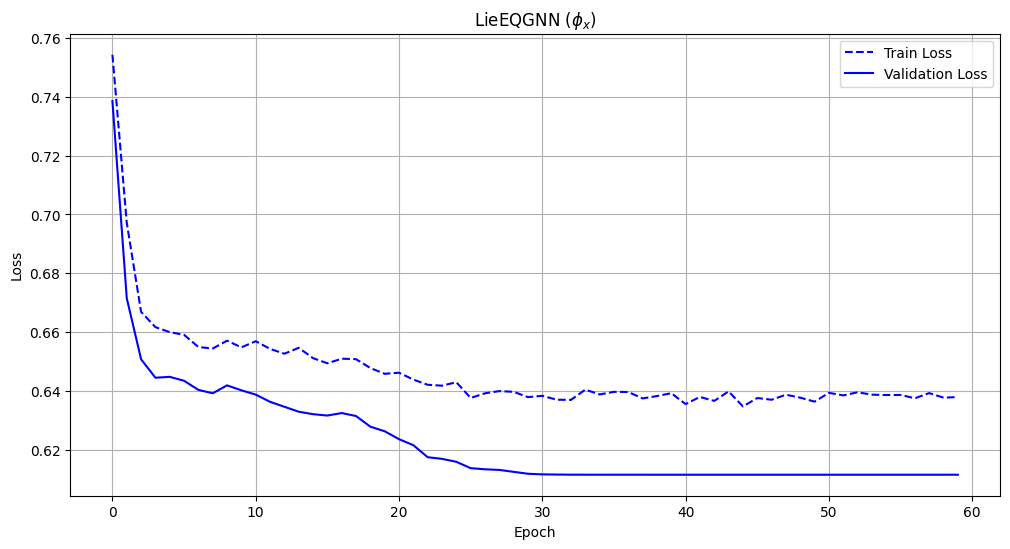

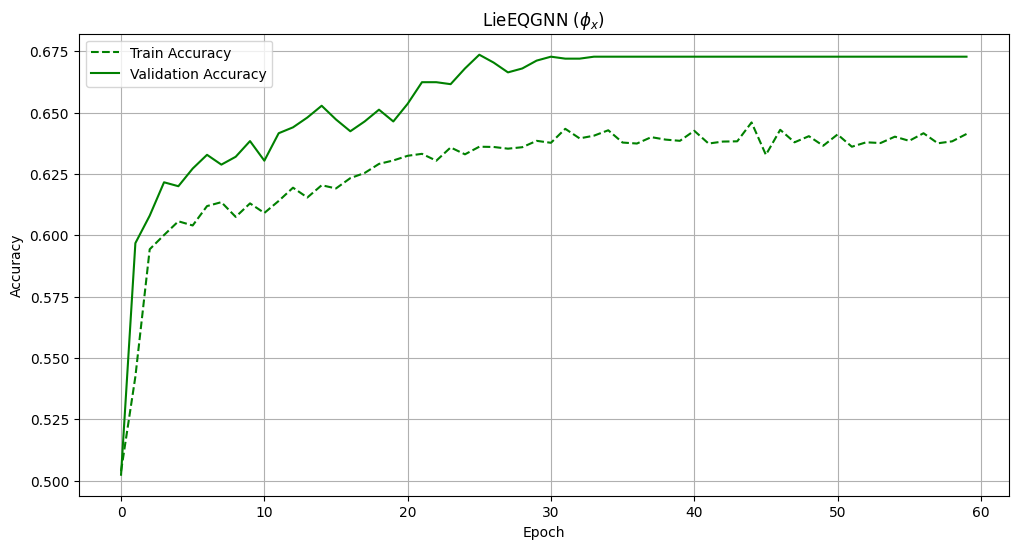

In [23]:
with open(log_path) as f:

    data = json.load(f)
    epochs = data["epochs"]
    train_loss = data["train_loss"]
    val_loss = data["val_loss"]
    train_acc = data["train_acc"]
    val_acc = data["val_acc"]
    
    # Plotting Loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, label='Train Loss', color='blue', linestyle='--')
    plt.plot(epochs, val_loss, label='Validation Loss', color='blue', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(model_name)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plotting Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_acc, label='Train Accuracy', color='green', linestyle='--')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='green', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(model_name)
    plt.legend()
    plt.grid(True)
    plt.show()

## References

[1] Neto, Jogi Suda, et al. "[Lie-Equivariant Quantum Graph Neural Networks.](https://arxiv.org/abs/2411.15315)" arXiv preprint arXiv:2411.15315 (2024).

[2] Shlomi, et al. "[Graph neural networks in particle physics.](https://arxiv.org/abs/2007.13681)" Machine Learning: Science and Technology 2.2 (2020): 021001.

[2] Jonas M. Kübler, et al. "[The inductive bias of quantum kernels](https://proceedings.neurips.cc/paper/2021/file/69adc1e107f7f7d035d7baf04342e1ca-Paper.pdf)", 2021.

[3] Jarrod R. McClean, et al. "[Barren plateaus in quantum neural network training landscapes](https://www.nature.com/articles/s41467-018-07090-4)". Nature Communications, 9(1), November 2018.

[4] M. Cerezo, et al. "[Cost function dependent barren plateaus in shallow parametrized quantum circuits](https://www.nature.com/articles/s41467-021-21728-w)". Nature Communications, 12(1), March 2021.

[5] Tüysüz, Cenk, et al. "[Symmetry breaking in geometric quantum machine learning in the presence of noise.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.5.030314)" PRX Quantum 5.3 (2024): 030314.

[5] Forestano, Roy T., et al. "[Deep learning symmetries and their Lie groups, algebras, and subalgebras from first principles.](https://arxiv.org/abs/2301.05638)" Machine Learning: Science and Technology 4.2 (2023): 025027.

[6] Gong, S., et al. "An Efficient Lorentz Equivariant Graph Neural Network for Jet Tagging" [arXiv:2201.08187](https://arxiv.org/abs/2201.08187).

[7] Komiske, P. T., Metodiev, E. M., & Thaler, J. "EnergyFlow: A Python Package for High Energy Physics." [EnergyFlow](https://energyflow.network/).